In [1]:
# Useful additional packages 
import matplotlib.pyplot as plt
import numpy as np
from math import pi

In [2]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile, Aer, execute, assemble
from qiskit.tools.visualization import circuit_drawer, plot_bloch_multivector, plot_histogram
import qiskit.quantum_info as qi


In [3]:
# pip install qiskit_ibm_provider


In [4]:
# from qiskit import IBMQ
# IBMQ.load_account()
# provider = IBMQ.get_provider(hub='ibm-q-wits', group='internal', project='stellenbosch-uni')


# Functions

**Me Completing Hjalmar:**

In [5]:
"""Calculates expectation value of a witness operator.

Takes as input a Qiskit counts dictionary for a set of physically measured
operators
"""


def compare(pauli_str_wit, pauli_str_exp):
    """Check whether pauli_wit can be derived from pauli_exp.
    i.e. we want to know whether all non-'I' entries of pauli_wit match up
    with pauli_exp
    """
    all_match = True
    for i in range(len(pauli_str_wit)):
        if pauli_str_wit[i] != 'I':
            if pauli_str_wit[i] != pauli_str_exp[i]:
                all_match = False

    return all_match

def expectation_from_counts(op_str, counts):
    """Calculate the expectation value of multi-qubit operator.

    Takes as input a Qiskit counts dict. If the operator contains identities
    the counts dict for a different but matching operator may be substituted.

    e.g. for 'XIXI' the counts dict of 'XYXZ' may be used.
    """
    expectation_val = 0
    for outcome, outcome_count in counts.items():
        eigval = 1
        for i in range(len(op_str)):
            if op_str[i] != 'I':
                eigval *= -1 if outcome[i] == '1' else 1

        expectation_val += eigval * outcome_count

    return expectation_val


# Define the function to calculate expectation value of W_CNOT

def calculate_expectation_value(basis_wit, bases_exp, counts):
    """Calculate the expectation value of a witness operator.

    Takes as input the witness operator basis, a list of expected operator bases,
    and a Qiskit counts dictionary for a set of physically measured operators.

    Parameters:
    - basis_wit (list of tuples): List of tuples, each containing the sign and Pauli string of a witness operator.
    - bases_exp (list of strings): List of expected operator bases.
    - counts (dict): Qiskit counts dictionary containing the outcomes of quantum measurements.

    Returns:
    - float: The calculated expectation value of the witness operator.
    """
    expectation_val_wit = 0
    for tup in basis_wit:
        sign = tup[0]
        pauli_str_wit = tup[1]

        for pauli_str_exp in bases_exp:
            if compare(pauli_str_wit, pauli_str_exp):
                expectation_val_wit += sign * expectation_from_counts(pauli_str_exp, counts)
                break

    expectation_val_wit /= total_shots

    return expectation_val_wit



# States & Operators Definitions:

In [6]:
XX = qi.Pauli('XX')
YY = qi.Pauli('YY') 
ZZ = qi.Pauli('ZZ')
II = qi.Operator.from_label('II')

# Matrix representations of Pauli operators
XX_matrix = XX.to_matrix()
YY_matrix = YY.to_matrix()
ZZ_matrix = ZZ.to_matrix()
II_matrix = np.eye(4)


# Define the maximally entangled state |α⟩⟨α|
alpha = np.array([0, 1, -1, 0]) / np.sqrt(2)
alpha_density_matrix = np.outer(alpha, alpha.conj())
print(alpha_density_matrix)


# Bell's Density matrices:

v00 = qi.Statevector.from_label('00')
v01 = qi.Statevector.from_label('01')
v10 = qi.Statevector.from_label('10')
v11 = qi.Statevector.from_label('11')

PhiPlus = qi.DensityMatrix(1/np.sqrt(2)*(v00+v11))
PhiMinus = qi.DensityMatrix(1/np.sqrt(2)*(v00-v11))
PsiPlus = qi.DensityMatrix(1/np.sqrt(2)*(v01+v10))
PsiMinus = qi.DensityMatrix(1/np.sqrt(2)*(v01-v10))

# Bell_state_list = [PhiPlus, PhiMinus, PsiPlus, PsiMinus]


[[ 0.   0.  -0.   0. ]
 [ 0.   0.5 -0.5  0. ]
 [-0.  -0.5  0.5 -0. ]
 [ 0.   0.  -0.   0. ]]


# Warner State & Witness Operator:

In [7]:
#  Numpy:
# Create the Werner density matrix ρₚ
werner_density_matrix_lambda = lambda p: (1 - 4/3 * p) * alpha_density_matrix + (p/3) * II_matrix

# Create the Witness Operator
Witness_EB_matrix = 0.5 * (II_matrix + XX_matrix + YY_matrix + ZZ_matrix)

# Same with Qskit:
werner_density_matrix_lambda_qiskit = lambda p: (1 - 4/3 * p) * PsiMinus + (p/3) * II       # No sure which Bell state
Witness_EB = 0.5 * (II + XX + YY + ZZ)                                              # Signs !

# Tests:
print("Trace in Numpy is:", np.trace(werner_density_matrix_lambda(0)))
print("Trace in Qiskit is:", werner_density_matrix_lambda_qiskit(0).trace())
print()
print("Type in Numpy is:", type(werner_density_matrix_lambda(0)))
print("Type in Qiskit is:", type(werner_density_matrix_lambda_qiskit(0)))
print()
print("Werner state Numpy:")
print()
print(werner_density_matrix_lambda(0))
print()
print("Werner state Qiskit:")
print()
print(werner_density_matrix_lambda_qiskit(0))

Trace in Numpy is: 0.9999999999999998
Trace in Qiskit is: (0.9999999999999998+0j)

Type in Numpy is: <class 'numpy.ndarray'>
Type in Qiskit is: <class 'qiskit.quantum_info.states.densitymatrix.DensityMatrix'>

Werner state Numpy:

[[ 0.   0.   0.   0. ]
 [ 0.   0.5 -0.5  0. ]
 [ 0.  -0.5  0.5  0. ]
 [ 0.   0.   0.   0. ]]

Werner state Qiskit:

DensityMatrix([[ 0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j],
               [ 0. +0.j,  0.5+0.j, -0.5+0.j,  0. +0.j],
               [ 0. +0.j, -0.5+0.j,  0.5+0.j,  0. +0.j],
               [ 0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j]],
              dims=(2, 2))


# Applying & Ploting 
* Applying $W_{EB}$ on $\rho_p$, the Werner density matrix, fro diffrent values of $p\in [0,1]$, and ploting
* The process is done in both Qiskit and Numpy (for practice and debugging)

In [8]:
# Parameters
p_list = list(np.linspace(0, 1, 100))
trace_list = []
trace_list_qiskit = []

for val in p_list:
    witness_werner = Witness_EB_matrix @ werner_density_matrix_lambda(val)
    # print(witness_werner)
    # witness_werner = qi.DensityMatrix(werner_density_matrix_lambda(val)).evolve(qi.Operator(Witness_EB_matrix))
    Tr_witness_werner = np.trace(witness_werner)
    trace_list.append(Tr_witness_werner)
    
    witness_werner_qiskit = Witness_EB @ werner_density_matrix_lambda_qiskit(val).to_operator()
    # witness_werner_qiskit = Witness_EB.data @ werner_density_matrix_lambda_qiskit(val).data # Also an option
    
    Tr_qiskit = np.trace(witness_werner_qiskit)
    # Tr_qiskit = witness_werner_qiskit.trace() # rasies an error 
    trace_list_qiskit.append(Tr_qiskit)
    
## Plot the results
# plt.plot(p_list, trace_list, label='By Numpy')
# plt.plot(p_list, trace_list_qiskit, label='By Qiskit')
# plt.xlabel('p')
# plt.ylabel('Trace')
# plt.title('Trace of Witness_EB_matrix * Werner density matrix')
# plt.grid()
# plt.legend()
# plt.show()


# Section $III$ :

<!-- # Not Necessarily Useful... (Focused on Sec.III at the Moment)
**Witness Operators for general PPT Channels - steps:** 

* We want to detect entanglement in NPT/PPT map; $\mathcal{M}$
* We difiene the witness operator:
* $$W_{PPT}= \ket{\lambda_{-}} \bra{\lambda_{-}}^\mathcal{T_A}$$
* $\ket{\lambda_{-}}$ is most negative value of the NPT (or PPT, right?) map $\mathcal{M}$
* For the general case I will probably implement $W_{PPT}$ by Eq.(40) from the main paper


* **Reading on Witness in general**
* **Ref.(7) (idea)**
* **Sec.V** -->

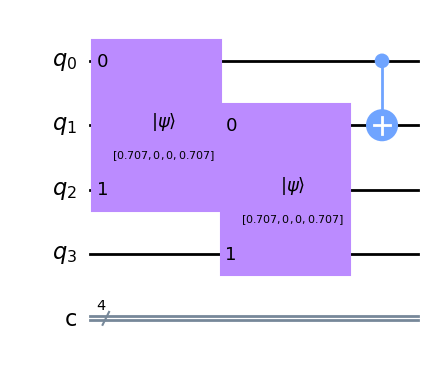

In [42]:
# Bell's Density matrices:
# v00, v01, v10, v11, PhiPlus, PhiMinus, PsiPlus, PsiMinus are defined here

# Step 1: Create the quantum circuit
qc = QuantumCircuit(4, 4)

# Choose Bell states for qubits AC and BD
rho_AC = PhiPlus  # Choose the desired Bell state for qubits AC
rho_BD = PhiPlus  # Choose the desired Bell state for qubits BD

# Extract amplitudes from the density matrices
amplitudes_AC = np.sqrt(np.diag(rho_AC.data))
amplitudes_BD = np.sqrt(np.diag(rho_BD.data))

# Apply initialization to qubits AC and BD
qc.initialize(amplitudes_AC, [0, 2])
qc.initialize(amplitudes_BD, [1, 3])

# Apply CNOT gate on qubits A and B
qc.cx(0, 1) # temp cx ---> cz

# Visualize the circuit without measurements
qc.draw('mpl')



$W_{CNOT}=$
$\frac{1}{64}[31*1111−1X1X−XXX1−X1XX−ZZ1Z+ZY1Y +YYXZ+YZXY−Z1Z1−ZXZX+YXY 1+Y1YX−1ZZZ+1YZY +XYYZ+XZYY]$

By the paper, the expectation values of operators: [$1X1X$ , $XXX1$ , $X1XX$]

can be obtained by measuring the operator XXXX and suitably processing the experimental data.

Similar groupings can be done for the other terms in $W_{CNOT}$

In [41]:
# Define the measurement bases
bases_exp = ['XXXX', 'ZZZZ', 'ZYZY', 'YXYX', 'YYXZ', 'YZXY', 'ZXZX', 'XYYZ', 'ZXYY']

bases_wit = [(31, 'IIII'),(-1, 'IXIX'),(-1, 'XXXI'),(-1, 'XIIX'),
             (-1, 'ZZIZ'),(+1, 'ZYIY'),(+1, 'YYXZ'),(+1, 'YZXY'),
             (-1, 'ZIZI'),(-1, 'ZXZX'),(+1, 'YXYI'),(+1, 'YIYX'),
             (-1, 'IZZZ'),(+1, 'IYZY'),(+1, 'XYYZ'),(+1, 'XZYY')]

# Use Aer's qasm_simulator
backend_sim = Aer.get_backend('qasm_simulator')

# Loop over each basis_wit
expectation_values = []
for basis_wit in bases_wit:
    temp_qc = qc.copy()

    # Apply gates for the specified basis_wit
    for i, gate in enumerate(basis_wit[1]):  # Use basis_wit[1] to access the Pauli string
        if gate == 'X':
            temp_qc.h(i)
        elif gate == 'Y':
            temp_qc.sdg(i)
            temp_qc.h(i)

    # Measure the circuit
    temp_qc.measure([0, 1, 2, 3], [0, 1, 2, 3])

    # Execute the circuit on the qasm simulator.
    total_shots = 1024
    job_sim = backend_sim.run(transpile(temp_qc, backend_sim), shots=total_shots)

    # Grab the results from the job.
    result_sim = job_sim.result()

    # Get counts
    counts = result_sim.get_counts()

    # Calculate the expectation value for the current basis_wit
    expectation_val = calculate_expectation_value([basis_wit], bases_exp, counts)
    expectation_values.append(expectation_val)


#     # Plot histogram using matplotlib (Optional)
    
#     plt.figure(figsize=(8, 6))
#     plt.bar(counts.keys(), counts.values())
#     plt.xlabel('Measurement')
#     plt.ylabel('Counts')
#     plt.title(f'Histogram for basis {basis_wit[1]}')  # Use basis_wit[1] to display the Pauli string
#     plt.show()

# Print the average of expectation values
print("Average of expectation values:", sum(expectation_values) / len(expectation_values))


Average of expectation values: -0.1597900390625


# **Hjalmar raw code +  other duplications:**
1. **Hjalmar raw code:** 

In [11]:


# # bases_exp = ['XXXX', 'ZZZZ', 'ZYZY', 'YXYX', 'YYXZ', 'YZXY', 'ZXZX', 'XYYZ', 'ZXYY']

# # bases_wit = [(1, 'IIII'),(-1, 'IXIX'),(-1, 'XXXI'),(-1, 'XIIX'),
# #              (-1, 'ZZIZ'),(+1, 'ZYIY'),(+1, 'YYXZ'),(+1, 'YZXY'),
# #              (-1, 'ZIZI'),(-1, 'ZXZX'),(+1, 'YXYI'),(+1, 'YIYX'),
# #              (-1, 'IZZZ'),(+1, 'IYZY'),(+1, 'XYYZ'),(+1, 'XZYY')]

# def compare(pauli_str_wit, pauli_str_exp):
#     """Check whether pauli_wit can be derived from pauli_exp.

#     i.e. we want to know whether all non-'I' entries of pauli_wit match up
#     with pauli_exp
#     """
#     all_match = True
#     for i in len(pauli_str_wit):
#         if pauli_str_wit[i] != 'I':
#             if pauli_str_wit[i] != pauli_str_exp[i]:
#                 all_match = False

#     return all_match


# def expectation_from_counts(op_str, counts):
#     """Calculate the expectation value of multi-qubit operator.

#     Takes as input a Qiskit counts dict. If the operator contains identities
#     the counts dict for a different but matching operator may be substituted.

#     e.g. for 'XIXI' the counts dict of 'XYXZ' may be used.
#     """
#     expectation_val = 0
#     for outcome, outcome_count in counts.items():
#         eigval = 1
#         for i in len(op_str):
#             if op_str[i] != 'I':
#                 eigval *= -1 if counts[i] == 1 else 1 

#         expectation_val += eigval*outcome_count # Should we divide by the total number of counts in the dictionary (1024) ?

#     return expectation_val


# expectation_val_wit = 0
# # for each operator in witness (thing we want to calculate)
# for tup in bases_wit:
#     # item is a tuple (sign, pauli_str_wit)
#     sign = tup[0]  # first element of tuple
#     pauli_str_wit = tup[1]  # second element of tuple

#     # loop through exp operators until we find a match
#     for pauli_str_exp in bases_exp:
#         if compare(pauli_str_wit, pauli_str_exp):
#             expectation_val_wit += sign * expectation_from_counts(pauli_str_wit, counts)
#             break

# expectation_val_wit /= (1/64)*[]  # I can't remember what the actual value is here
# print(expectation_val_wit)

2. **Section III Raw:**

In [12]:
# # Bell's Density matrices:
# # v00, v01, v10, v11, PhiPlus, PhiMinus, PsiPlus, PsiMinus are defined here

# # Step 1: Create the quantum circuit
# qc = QuantumCircuit(4)
# # cr =ClassicalRegister(4,'cr')

# # Choose Bell states for qubits AC and BD
# # α = 
# rho_AC = PhiPlus  # Choose the desired Bell state for qubits AC
# # rho_BD = 1/np.sqrt(2)(α +PsiMinus)  # Choose the desired Bell state for qubits BD
# rho_BD = PhiPlus # Choose the desired Bell state for qubits BD

# # Define the measurement bases
# bases = ['XXXX', 'ZZZZ', 'ZYZY', 'YXYX', 'YYXZ', 'YZXY', 'ZXZX', 'XYYZ', 'ZXYY']


# # Extract amplitudes from the density matrices
# amplitudes_AC = np.sqrt(np.diag(rho_AC.data))
# amplitudes_BD = np.sqrt(np.diag(rho_BD.data))

# # Apply initialization to qubits AC and BD
# qc.initialize(amplitudes_AC, [0, 2])
# qc.initialize(amplitudes_BD, [1, 3])

# # Apply CNOT gate on qubits A and B
# qc.cx(0, 1)

# # Visualize the circuit
# # print(qc)
# qc.draw('mpl')

# # qc.measure([0,1,2,3],[0,1,2,3])

# # # Use Aer's qasm_simulator
# # backend_sim = Aer.get_backend('qasm_simulator')

# # # Execute the circuit on the qasm simulator.
# # # We've set the number of repeats of the circuit
# # # to be 1024, which is the default.
# # job_sim = backend_sim.run(transpile(qc, backend_sim), shots=(1024))

# # # Grab the results from the job.
# # result_sim = job_sim.result()


3. **Worrng,Using: check_bit_parity_odd:**

In [13]:
# # # Define the measurement bases
# # bases_exp = ['XXXX', 'ZZZZ', 'ZYZY', 'YXYX', 'YYXZ', 'YZXY', 'ZXZX', 'XYYZ', 'ZXYY']

# # bases_wit = [(1, 'IIII'),(-1, 'IXIX'),(-1, 'XXXI'),(-1, 'XIIX'),
# #              (-1, 'ZZIZ'),(+1, 'ZYIY'),(+1, 'YYXZ'),(+1, 'YZXY'),
# #              (-1, 'ZIZI'),(-1, 'ZXZX'),(+1, 'YXYI'),(+1, 'YIYX'),
# #              (-1, 'IZZZ'),(+1, 'IYZY'),(+1, 'XYYZ'),(+1, 'XZYY')]


# # Use Aer's qasm_simulator
# backend_sim = Aer.get_backend('qasm_simulator')
# # Loop over each basis
# for basis in bases:
#     temp_qc = qc.copy()

#     # Apply gates for the specified basis
#     for i, gate in enumerate(basis):
#         if gate == 'X':
#             temp_qc.h(i)
#         elif gate == 'Y':
#             temp_qc.sdg(i)
#             temp_qc.h(i)
            
#     # Measure the circuit
#     temp_qc.measure([0, 1, 2, 3], [0, 1, 2, 3])

#     # Execute the circuit on the qasm simulator.
#     total_shots = 1024
#     job_sim = backend_sim.run(transpile(temp_qc, backend_sim), shots=total_shots)

#     # Grab the results from the job.
#     result_sim = job_sim.result()

#     # Get counts
#     counts = result_sim.get_counts()
    

#     # Set the figure size for better layout
#     plt.figure(figsize=(8, 6))

#     # Plot histogram using matplotlib
#     plt.bar(counts.keys(), counts.values())
#     plt.xlabel('Measurement')
#     plt.ylabel('Counts')
#     plt.title(f'Histogram for basis {basis}')
#     plt.show()
    
#     avg = 0  # I want to replace this by using the new functions.
#     for x,y in counts.items():
#         print(check_bit_parity_odd(x),y)
#         avg+= -y if check_bit_parity_odd(x) else y
#     avg/=1024
#     print(avg)

# Dumb Stuff 

In [14]:
# from nbformat import read

# # Load the Jupyter notebook file
# with open('QC_Detection.ipynb', 'r') as nb_file:
#     nb = read(nb_file, as_version=4)

# # Count the total number of lines in code cells
# total_lines = sum(len(cell['source'].split('\n')) for cell in nb.cells if cell.cell_type == 'code')

# print("Total lines of code:", total_lines)

Total lines of code: 417
